# Implementation of the SiPM response functions

This repository attempts to implement the SiPM low light response functions
describe in [arXiv:1609.01181][sipm_response] in a python library to allow for
the interfacing with the broader data analysis tools used by HEP. In this
notebook we will mainly break down the mathematical components that go into the
description given in the paper. And these functions are implemented in the
`sipmpdf.functions` module.

[sipm_response]: https://arxiv.org/pdf/1609.01181.pdf


In [1]:
import sipmpdf
import sipmpdf.pdf as PDF
import matplotlib.pyplot as plt
import numpy as np
import mplhep
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

/srv/.env/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## The generalized Poisson distribution

The [Generalized Poisson distribution][gen_poisson] $GP(x;\mu,\lambda)$ is used
to model the deviation from a simple Poisson distribution due to in-time
correlated discharged driven by optical crosstalk within the SiPM.

$$
GP(k;\mu\lambda) = \frac{\mu(\mu + \lambda x)^{k-1}}{k!}\exp(-(\mu+\lambda x))
$$

This function is implemented as `sipmpdf.functions.generalized_poisson`.

[gen_poisson]: https://www.jstor.org/stable/1267389


Text(0, 0.5, 'Probablity')

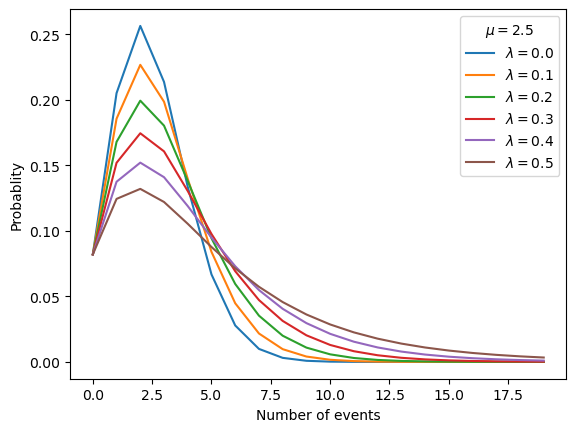

In [2]:
n = np.arange(20)
mu = 2.5

for idx, borel in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]):
  plt.plot(n,
           sipmpdf.functions.generalized_poisson(n, mu, borel),
           color=COLORS[idx],
           label=f'$\lambda={borel}$')
plt.legend(title='$\mu=2.5$')
plt.xlabel('Number of events')
plt.ylabel('Probablity')

## A Gaussian smeared General Poisson distribution

Here we provide a model that excludes other nonlinear effects other than cross
talk. This is given by the convolution of the General Poisson distribution
smeared by a Gaussian noise. The PDF of this model is given as: 

$$
P(x;p, g, \mu, \lambda, \sigma_0, \sigma_1) = 
\sum_{n=0}^{\infty} GP(n;\mu,\lambda) \cdot  
N(x; p + ng, \sqrt{\sigma_0^2 + p\sigma_1^2})
$$

Where $GP$ is the general poisson distribution (shown previously), and
$N(x;m,\sigma)$ is the Gaussian distribution a mean value $m$ and standard
deviation $\sigma$. 

[-100.          -99.49974987  -98.99949975 ...  898.99949975  899.49974987
  900.        ] [4.87634153e-13 6.08710458e-13 7.59004548e-13 ... 1.12990136e-03
 1.13160600e-03 1.13217479e-03]


Text(30, 0.0005927525971697381, '')

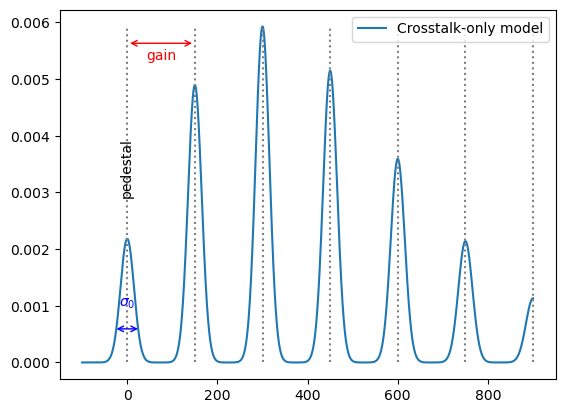

In [3]:
x = np.linspace(-100, 900, 2000)
y = sipmpdf.functions.sipm_response_no_dark_no_ap(x,
                                             pedestal=0,
                                             gain=150,
                                             common_noise=15,
                                             pixel_noise=2,
                                             poisson_mean=2.5,
                                             poisson_borel=0.1)
print(x, y)
plt.plot(x, y, label=f'Crosstalk-only model')
ymax = np.max(y)
plt.legend()
#plt.yscale('log')
plt.vlines(150 * np.arange(7),
           ymin=0,
           ymax=np.max(y),
           color='gray',
           linestyles='dotted')
plt.annotate('pedestal', [0, ymax * 0.5], rotation=90, ha='center')
plt.annotate('gain', [75, ymax * 0.9], ha='center', color='red')
plt.annotate('',
             xy=(0, ymax * 0.95),
             xytext=(150, ymax * 0.95),
             arrowprops=dict(arrowstyle='<->', color='red'))

plt.annotate('$\sigma_0$', [0, 0.001], ha='center', color='blue')
plt.annotate('',
             xy=(-30, ymax * 0.1),
             xytext=(30, ymax * 0.1),
             arrowprops=dict(arrowstyle='<->', color='blue'))


Though this will not be official supported, the user can implement a simple
z-fit PDF to use this model. We are going to give a stand along example here, as
the full response function is even more expensive to compute. Notice since the
evaluation of functions is expensive, users should attempt to use a binned fit
where ever possible. Here we first declare the objects required for the fit:

In [4]:
import zfit


# Simple declaration of the zfit PDF
class DemoSiPMPDF(zfit.pdf.ZPDF):
  _N_OBS = 1
  _PARAMS = [
    'pedestal', 'gain', 'common_noise', 'pixel_noise', 'poisson_mean',
    'poisson_borel'
  ]

  def _unnormalized_pdf(self, x):
    x = zfit.z.unstack_x(x)
    return sipmpdf.functions.sipm_response_no_dark_no_ap(
      x, **{k: self.params[k]
            for k in self._PARAMS})


# Declaring the variables of interest
pedestal = zfit.Parameter('pedestal value 1', 5.0, -10, 50)
gain = zfit.Parameter('gain 1', 150.0, 100, 200)
common_noise = zfit.Parameter('common_noise 1', 15.0, 5, 25)
pixel_noise = zfit.Parameter('pixel_noise 1', 2.0, 1, 3)
poisson_mean = zfit.Parameter('poisson_mean 1', 2.5, 2, 3)
poisson_borel = zfit.Parameter('poisson_borel 1', 0.0, 0, 0.1)
obs = zfit.Space('x', limits=(-200, +1500))

# Declaring the "unbinned" PDF
pdf = DemoSiPMPDF(obs=obs,
                  pedestal=pedestal,
                  gain=gain,
                  common_noise=common_noise,
                  pixel_noise=pixel_noise,
                  poisson_mean=poisson_mean,
                  poisson_borel=poisson_borel)

# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1800, name="x")
obs_bin = zfit.Space("x", binning=binning)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)


Then we can generate pseudo data using the random number generation provided in
numpy.


In [5]:
# Number of discharges following the regular Poisson distribution
n_pe = np.random.poisson(lam=2.5, size=100_000)
# For each discharge there is a set random uncertainty
noise = np.sqrt(15.0**2 + n_pe * 2.0**2)
# We run a second smearing using the random normal distribution
data_array = np.random.normal(size=100_000, loc=n_pe * 150 + 5, scale=noise)

# First we construct the unbinned data
data_unbinned = zfit.Data.from_numpy(obs=obs, array=data_array)
# Then the binned data
data_bin = data_unbinned.to_binned(obs_bin)


Next we can run the minizer:

In [6]:
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

/srv/.env/lib/python3.8/site-packages/sipmpdf/kernel.py:78: UserWarning: Using tensorflow.experimental.numpy.sum. Make sure the functionality has been implemented!
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1180: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fdee46f89a0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fdee4520820>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ False   │ True        │ True             │ 1.8e-05 │ 846.1993    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name                value  (rounded)        hesse    at limit
----------------  ------------------  -----------  ----------
pedestal value 1             5.07262  +/-   0.091       False
gain 1                       149.992  +/-   0.031       False
common_noise 1               14.9946  +/-   0.065       False
pixel_noise 1                2.05399  +/-    0.17       False
poisson_mean 1               2.48869  +/-   0.005  

We can also invoke the various facility to plot the fit results:

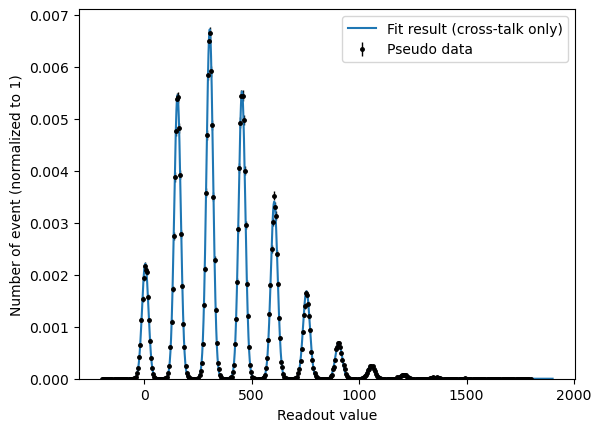

In [7]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(h,
                     density=True,
                     label='Pseudo data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)
plt.plot(x, y, label='Fit result (cross-talk only)')
plt.xlabel('Readout value')
plt.ylabel('Number of event (normalized to 1)')
plt.legend()


## Afterpulse response

Here we provide a function which models the spectrum of the afterpulse response given by a fixed number of photoelectron discharges while accounting for noise

We first start by modeling the spectrum for a fixed number of photoelectron discharges with a fixed number of afterpulses greater than 0 (including noise) given by the equations: 
$$
i=0 \qquad A(x,i=0,k,p,k,g,\sigma_k) = B(0,k,P_{a.p.})G(x;p+kg,\sigma_{k})
$$

$$
i>1 \qquad A(x;1,k,\beta) = \frac{(x-p_k)^{i-1}}{(i-1)!\beta^i}exp(-\frac{x-p_k}{\beta})\Theta(x-p_k))
$$

$$
i=1 \qquad  A(x,1,k,\beta) \sim \frac{1}{2\beta}exp(-\frac{x-p_k}{\beta})(1+erf(\frac{x-p_k}{\sigma_k\sqrt{2}}))
$$

Here $\beta$ determines the shape of the exponential function, $p_k=p+kg$, where $p$ is the pedstal value, $k$ is the number of prompt photoelectron discharges, $g$ is the gain, $i$ is the number of afterpulses, and $\Theta$ is the heaviside step function. 

In our implementation of the function the factor $x-p_k$ is taken together as one input variable, thus $k$,$g$ and $p$ are not explicit variables and we set $p_k=0$.



/srv/.env/lib/python3.8/site-packages/sipmpdf/functions.py:224: RuntimeWarning: invalid value encountered in log
  kern.log(kern.power(x, n_ap - 1)) - kern.log(kern.power(beta, n_ap)) -


Text(0.5, 1.0, 'Afterpulse Response for Fixed Photoelectrons and Afterpulses')

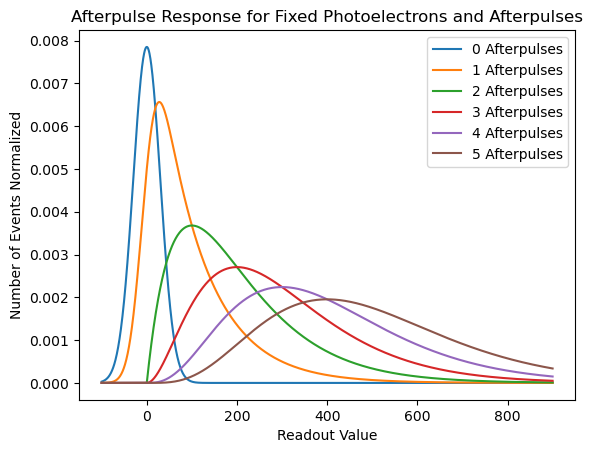

In [8]:
x = np.linspace(-100, 900, 2000)

zero_ap_response=sipmpdf.functions.binomial_prob(x=0, total=5, prob=.1)*sipmpdf.functions.normal(x=x, mean=0, scale=30)

single_ap_response=sipmpdf.functions.ap_response_smeared(x=x,
                                       smear=25,
                                       n_ap=1,
                                       beta=100)

two_ap_response=sipmpdf.functions.ap_response_smeared(x=x,
                                                     smear=25,
                                                     n_ap=2,
                                                     beta=100)
three_ap_response=sipmpdf.functions.ap_response_smeared(x=x,
                                                       smear=25,
                                                       n_ap=3,
                                                       beta=100)
four_ap_response=sipmpdf.functions.ap_response_smeared(x=x,
                                                       smear=25,
                                                       n_ap=4,
                                                       beta=100)
five_ap_response=sipmpdf.functions.ap_response_smeared(x=x,
                                                       smear=25,
                                                       n_ap=5,
                                                       beta=100)
plt.plot(x, zero_ap_response, label=f'0 Afterpulses')
plt.plot(x, single_ap_response, label=f'1 Afterpulses')
plt.plot(x, two_ap_response, label=f'2 Afterpulses')
plt.plot(x, three_ap_response, label=f'3 Afterpulses')
plt.plot(x, four_ap_response, label=f'4 Afterpulses')
plt.plot(x, five_ap_response, label=f'5 Afterpulses')
plt.legend()
plt.xlabel('Readout Value')
plt.ylabel('Number of Events Normalized')
plt.title('Afterpulse Response for Fixed Photoelectrons and Afterpulses')


We combine these responses together and weight them by the probability of having $i$ afterpulses via a binomial distribution. Given that the probability of each of the responses decreases as $i$ increases, we only consider the responses of $i$ from 1 to 10. 

We also include the response for no afterpulses where $i=0$, again weighted by binomial probability

Thus, the function giving the afterpulse response for $k$ photoelectron discharges is:

$$Sum(x;k,\beta,P_{a.p.})=B(0;k,P_{a.p.})G(x;p+kg,\sigma_k)+\sum_{i=1}^{10} B(i;k,P_{a.p.})A(x;i,k,\beta)$$

where $B(i;k,P_{a.p.})$ is the binomial probability of $i$ afterpulses given $k$ photoelectron discharges, there is a probability $P_{a.p.}$ of an afterpulse for each photoelectron discharge, and $\beta$ is defined as before.

Text(0.5, 1.0, 'Total Afterpulse Response for Fixed Number of Photoelectrons')

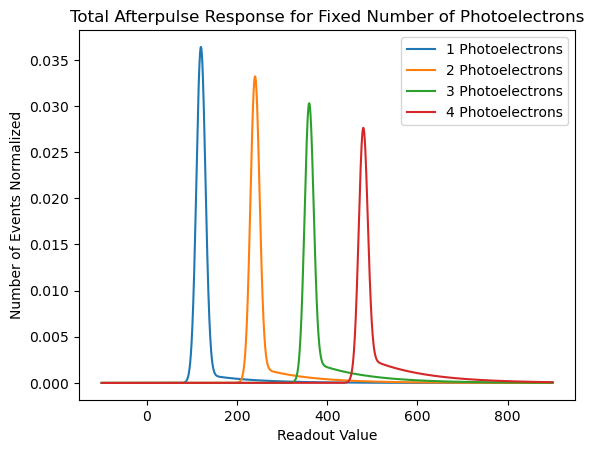

In [9]:
x = np.linspace(-100, 900, 2000)

sum_ap_response_1=sipmpdf.functions._full_afterpulse_response(x=x,ap_smear=15,ap_beta=100,ap_prob=.1,total=1,pedestal=0,gain=120,sigma_k=10)
sum_ap_response_2=sipmpdf.functions._full_afterpulse_response(x=x,ap_smear=15,ap_beta=100,ap_prob=.1,total=2,pedestal=0,gain=120,sigma_k=10)
sum_ap_response_3=sipmpdf.functions._full_afterpulse_response(x=x,ap_smear=15,ap_beta=100,ap_prob=.1,total=3,pedestal=0,gain=120,sigma_k=10)
sum_ap_response_4=sipmpdf.functions._full_afterpulse_response(x=x,ap_smear=15,ap_beta=100,ap_prob=.1,total=4,pedestal=0,gain=120,sigma_k=10)

plt.plot(x,sum_ap_response_1, label=f'1 Photoelectrons')
plt.plot(x,sum_ap_response_2, label=f'2 Photoelectrons')
plt.plot(x,sum_ap_response_3, label=f'3 Photoelectrons')
plt.plot(x,sum_ap_response_4, label=f'4 Photoelectrons')
plt.legend()
plt.xlabel('Readout Value')
plt.ylabel('Number of Events Normalized')
plt.title('Total Afterpulse Response for Fixed Number of Photoelectrons')

## Poisson x(Gaussian+AP)

The following example shows the the fitting for a SiPM response including gaussian and afterpulsing responses, without any dark current. This function takes the previous afterpulse response summation and weights each of those results by the generalized poisson distribution for k. This function also includes the response where k=0.

The function for this response is given as

$$F=GP(0;\mu,\lambda)G(x;p,\sigma_0)+ \sum_{k=1}GP(k;\mu,\lambda) \Biggl( B(0;k,P_{a.p.})G(x;p+kg,\sigma_k)+\sum_{i=1}^{10} B(i;k,P_{a.p.})A(x;i,k,\beta)\Biggr) $$

In [10]:
#Create pdf for the response with no dark current
pedestal= zfit.Parameter('pedestal 2', 5.0, -10, 50)
gain=zfit.Parameter('gain 2',120,100,200)
ap_beta=zfit.Parameter('beta 2',100,20,120)
ap_prob=zfit.Parameter('prob 2',.1,.05,.2)
common_noise=zfit.Parameter('common_noise 2',15.0,5,40)
pixel_noise=zfit.Parameter('pixel_noise 2',4.0,0,10)
poisson_mean=zfit.Parameter('poisson_mean 2',2.5,1,3)
poisson_borel=zfit.Parameter('poisson_borel 2',0,0.0,0.1)
obs = zfit.Space('x', limits=(-200, +1500))

pdf = PDF.SiPMResponse_NoDC_PDF(obs=obs,
                  pedestal=pedestal,
                  gain=gain,
                  ap_beta=ap_beta,
                  ap_prob=ap_prob,
                  common_noise=common_noise,
                  pixel_noise=pixel_noise,
                  poisson_mean=poisson_mean,
                  poisson_borel=poisson_borel)
# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1800, name="x")
obs_bin = zfit.Space("x", binning=binning)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)

In [11]:
#Create pseudodata for the response with no dark current
N_EVENTS = 1_000_000


gain = 120.
mu = 2.5 
beta = 100
prob_ap = 0.05

k = np.random.poisson(mu, size=N_EVENTS) # Number of primary discharges

ap_shape = (N_EVENTS,15) # Up to 10 after pulses per event

# Single ap discharge response
ap = np.random.exponential(beta, size=ap_shape) 
# Discarding AP responses if number of AP exceeds number of primary discharges 
ap = np.where( k[:,np.newaxis] > np.indices(ap_shape)[1], 0, ap ) 
# AP only has finite chance of appearing
ap = np.where(np.random.random(size=ap_shape) > prob_ap, 0, ap)

#Decide on the amount of random smearing based on the value of i
s0 = 15.
s1 = 2.

smearing=np.zeros(N_EVENTS)
smearing=np.where(np.count_nonzero(ap,axis=1)<1,np.sqrt(s0**2 + k*s1**2),0)
smearing=np.where(np.count_nonzero(ap,axis=1)==1,s0,smearing)

#Mark where to add gaussian smearking where i<2
gaussian=np.where(np.count_nonzero(ap,axis=1)<2,True,False)

#Constructing the response with no random smearing
response = k * gain + np.sum(ap,axis=-1)

#Add in gaussian smearing where applicable
response=np.where(gaussian==True,k*gain,response)
response=response+np.random.normal(loc=0,scale=smearing)

data_array=response

In [ ]:
# First we construct the unbinned data
data_unbinned = zfit.Data.from_numpy(obs=obs, array=data_array)
# Then the binned data
data_bin = data_unbinned.to_binned(obs_bin)

nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

/srv/.env/lib/python3.8/site-packages/sipmpdf/kernel.py:78: UserWarning: Using tensorflow.experimental.numpy.power. Make sure the functionality has been implemented!
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/sipmpdf/kernel.py:78: UserWarning: Using tensorflow.experimental.numpy.sum. Make sure the functionality has been implemented!
  warnings.warn(


In [ ]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(h,
                     density=True,
                     label='Pseudo data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)
plt.plot(x, y, label='Fit result (no dark current)')
plt.xlabel('Readout value')
plt.ylabel('Number of events (normalized to 1)')
plt.legend()

## Dark current response

This function is the dark current response which occurs when there are no photoelectric discharges (i.e. k=0) with a probability of $P_{d.c}$. The dark current response function as well as its response incuding noise is implemented here using a summation in order to speed up calculations.

$$ D(x)=\frac{1}{2*log(\frac{g}{\epsilon})}\biggl(\frac{1}{x-p}+\frac{1}{p+g-x} \biggr)$$

TODO: include changes made in order to smooth out the dark current

In [ ]:
x = np.linspace(-100, 500,2000)
dc=sipmpdf.functions.darkcurrent_response_smeared(x=x,smear=15,gain=120,resolution=10e-4)

plt.plot(x,dc,label="Dark Current Response Smeared")
plt.xlabel('Readout value')
plt.ylabel('Number of events (normalized to 1)')
plt.legend()

## Full SiPM Response Output

These cells demonstrate the full SiPM response including both afterpulsing and dark current. The function for this is given below as 

$$F=GP(0;\mu,\lambda)\Biggl((1-P_{d.c.})G(x;p,\sigma_0)+P_{d.c.}D_{smeared}(x)\Biggr)+ \sum_{k=1}GP(k;\mu,\lambda) \Biggl( B(0;k,P_{a.p.})G(x;p+kg,\sigma_k)+\sum_{i=1}^{10} B(i;k,P_{a.p.})A(x;i,k,\beta)\Biggr) $$

The pseudodata created below should be replaced with real generated data which the user desires to analyze, and the bounds of the various variables should be chosen as the reasonable limits for each.

In [ ]:
#Create pdf for the full response

#Variable creation: set the bounds and where to start the fitting
pedestal= zfit.Parameter('pedestal 4', 5.0, -10, 50)
gain=zfit.Parameter('gain 4',120,100,200)
ap_beta=zfit.Parameter('beta 4',100,40,120)
ap_prob=zfit.Parameter('prob 4',.1,.05,.4)
common_noise=zfit.Parameter('common_noise 4',15.0,5,25)
pixel_noise=zfit.Parameter('pixel_noise 4',2.0,1,3)
poisson_mean=zfit.Parameter('poisson_mean 4',2.5,2,3)
poisson_borel=zfit.Parameter('poisson_borel 4',0,0.0,0.1)
dc_prob=zfit.Parameter('dc_prob 4', .1,.01,.3)
dc_res =zfit.Parameter('dc_res 4', 10e-4,0,1)
obs = zfit.Space('x', limits=(-200, +1500))

pdf = PDF.SiPMResponsePDF(obs=obs,
                  pedestal=pedestal,
                  gain=gain,
                  ap_beta=ap_beta,
                  ap_prob=ap_prob,
                  common_noise=common_noise,
                  pixel_noise=pixel_noise,
                  poisson_mean=poisson_mean,
                  poisson_borel=poisson_borel,
                  dc_prob=dc_prob,
                  dc_res=dc_res)
# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1800, name="x")
obs_bin = zfit.Space("x", binning=binning)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)

In [ ]:
#Create pseudodata
N_EVENTS = 100_000

gain = 120.
mu = 2.5 
beta = 120
prob_ap = 0.05
prob_dc = .05

k = np.random.poisson(mu, size=N_EVENTS) # Number of primary discharges

ap_shape = (N_EVENTS,15) # Up to 10 after pulses per event

# Single ap discharge response
ap = np.random.exponential(beta, size=ap_shape) 
# Discarding AP responses if number of AP exceeds number of primary discharges 
ap = np.where( k[:,np.newaxis] > np.indices(ap_shape)[1], 0, ap ) 
# AP only has finite chance of appearing
ap = np.where(np.random.random(size=ap_shape) > prob_ap, 0, ap)

#Decide on the amount of random smearing based on the value of i
s0 = 15.
s1 = 2.

smearing=np.zeros(N_EVENTS)
smearing=np.where(np.count_nonzero(ap,axis=1)<1,np.sqrt(s0**2 + k*s1**2),0)
smearing=np.where(np.count_nonzero(ap,axis=1)==1,s0,smearing)

#Mark where to add gaussian smearing based on the value of i
gaussian=np.where(np.count_nonzero(ap,axis=1)<2,True,False)

# Constructing the response with no random smearing
response = k * gain + np.sum(ap,axis=-1)

#Insert gaussian smearing where applicable
response=np.where(gaussian==True,k*gain,response)
response=response+np.random.normal(loc=0,scale=smearing)

# Create dark current data, Integration window starting time relative to random discharge
# In units of sipm pulse time constant
start = np.random.uniform(-3,5, size=N_EVENTS) 

# Getting the integration results (assuming integration window width of 3)
neg = np.where(start < -3, 0, 1-np.exp(-(start+3))) 
pos = np.exp(-start) - np.exp(-(start+3))
dark_resp = np.where(start < 0, neg, pos) * gain

# Inject random noise into dark current response
dark_resp = dark_resp + np.random.normal(loc=0, scale=10, size=N_EVENTS)

#replace some k=0 values with dark current values
random_arr=np.random.rand(N_EVENTS)
random_arr=np.where(k==0,random_arr,2)
response=np.where(random_arr<prob_dc,dark_resp,response)

data_array=response

In [ ]:
# First we construct the unbinned data
data_unbinned = zfit.Data.from_numpy(obs=obs, array=data_array)
# Then the binned data
data_bin = data_unbinned.to_binned(obs_bin)

#Fit the equation to the data
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

In [ ]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(h,
                     density=True,
                     label='Pseudo data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)
plt.plot(x, y, label='Fit result')
plt.xlabel('Readout value')
plt.ylabel('Number of events (normalized to 1)')
plt.legend()